# This Notebook is Model Testing for MainGroup instances of Classification Codes

In [34]:
# Import all necessary packages

import ast
import nltk
import string
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import pyplot as plt

from prettytable import PrettyTable

# All Data

The subsequent section will test the performance of the following models on the whole dataset:

- Logistic Regression
- Random Forest Classifier
- Support Vector Machine
- Deep Nerual Networks


In [3]:
# Load the data
df = pd.read_csv('Data_Preprocessed_MainGroup.csv')
df['Classification Codes'] = df['Classification Codes'].apply(ast.literal_eval)
df.head()

,Context,Classification Codes
0,processor compil system receiv predict model r...,"[G06N5/00, G06N20/00]"
1,imag sens devic imag sens devic includ substra...,[H01L27/00]
2,antigen specif immunotherapi covid19 fusion pr...,"[C07K14/00, A61P31/00, A61K38/00, A61K39/00, C..."
3,secur deescal data access concept technolog di...,[G06F21/00]
4,system method secur cloudbas physiolog data pr...,"[G06F21/00, G16H40/00, A61B5/00, G16H10/00, A6..."


In [4]:
# As most multi-label classifiers requres each class to have multiple instances.
# All codes which appear less than 5 times will be removed

for i in range(10):

    # Determine the codes to be removed
    unique_codes = df['Classification Codes'].explode().value_counts()
    codes_to_remove = unique_codes[unique_codes < 5 ].index.tolist()

    # Remove rows with empty 'Classification Codes' column
    df = df.dropna(subset=['Classification Codes'])

    # Remove codes in the list codes_to_remove
    df['CodeCount'] = df['Classification Codes'].apply(lambda codes: sum(code in codes_to_remove for code in codes))
    df = df[df['CodeCount'] == 0].drop(columns=['CodeCount'])

In [5]:
# Now all codes will have a minimum of 5 instances
print(unique_codes)

A61B5/00     2563
A61B17/00    1749
G06T7/00     1367
G06K9/00     1141
A61B90/00    1052
             ... 
A61P23/00       5
G01N31/00       5
G01R27/00       5
G08G5/00        5
B64D47/00       5
Name: Classification Codes, Length: 450, dtype: int64


In [6]:
# Encode "Classification Codes" column as multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Classification Codes'])

# Split the data into training(80%) and testing sets(20%)
X_train, X_test, y_train, y_test = train_test_split(df['Context'], y, test_size=0.2, random_state=42)

In [7]:
# Apply feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## Logistic Regression 

In [8]:
logistic_regression = LogisticRegression()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(logistic_regression)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.0784452296819788
Hamming Loss: 0.008143698468786808


## Random Forest Classifier 


In [11]:
classifier = RandomForestClassifier()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.05265017667844523
Hamming Loss: 0.007224185316058108


## Support Vector Machine  (One vs Rest)


In [12]:
svm_classifier = SVC(kernel='linear')

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(svm_classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.06431095406360424
Hamming Loss: 0.009626226933647428


## Deep Neural Networks 

In [13]:
# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build basic deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Make predictions
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
hamming_loss_value = hamming_loss(y_test, y_pred)

2023-07-27 02:34:27.296705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
283/283 [==============================] - 6s 20ms/step - loss: 0.0801 - accuracy: 0.2027 - val_loss: 0.0319 - val_accuracy: 0.2990
Epoch 2/10
283/283 [==============================] - 6s 21ms/step - loss: 0.0271 - accuracy: 0.3335 - val_loss: 0.0274 - val_accuracy: 0.3344
Epoch 3/10
283/283 [==============================] - 6s 20ms/step - loss: 0.0213 - accuracy: 0.3847 - val_loss: 0.0259 - val_accuracy: 0.3560
Epoch 4/10
283/283 [==============================] - 6s 21ms/step - loss: 0.0177 - accuracy: 0.4049 - val_loss: 0.0254 - val_accuracy: 0.3644
Epoch 5/10
283/283 [==============================] - 6s 20ms/step - loss: 0.0150 - accuracy: 0.4260 - val_loss: 0.0259 - val_accuracy: 0.3573
Epoch 6/10
283/283 [==============================] - 6s 21ms/step - loss: 0.0130 - accuracy: 0.4421 - val_loss: 0.0266 - val_accuracy: 0.3693
Epoch 7/10
283/283 [==============================] - 6s 20ms/step - loss: 0.0114 - accuracy: 0.4491 - val_loss: 0.0275 - val_accuracy: 0.3516

In [14]:
# Get accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy and validation accuracy for each epoch
for epoch in range(len(accuracy)):
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")
    
# Print hamming loss
print("\nHamming Loss:", hamming_loss_value)

Epoch 1 - Accuracy: 0.2027, Validation Accuracy: 0.2990
Epoch 2 - Accuracy: 0.3335, Validation Accuracy: 0.3344
Epoch 3 - Accuracy: 0.3847, Validation Accuracy: 0.3560
Epoch 4 - Accuracy: 0.4049, Validation Accuracy: 0.3644
Epoch 5 - Accuracy: 0.4260, Validation Accuracy: 0.3573
Epoch 6 - Accuracy: 0.4421, Validation Accuracy: 0.3693
Epoch 7 - Accuracy: 0.4491, Validation Accuracy: 0.3516
Epoch 8 - Accuracy: 0.4630, Validation Accuracy: 0.3410
Epoch 9 - Accuracy: 0.4595, Validation Accuracy: 0.3454
Epoch 10 - Accuracy: 0.4665, Validation Accuracy: 0.3419

Hamming Loss: 0.007292500981546918


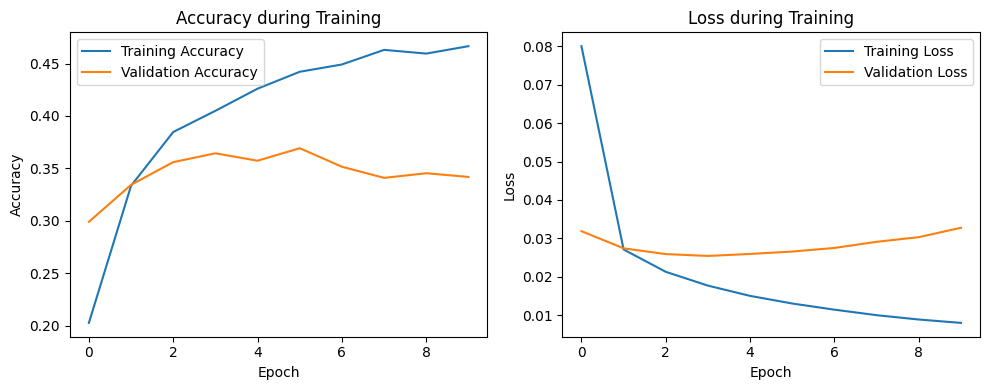

In [15]:
# Plot the training history
plt.figure(figsize=(10, 4))

# Accuracy/validation accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Loss/validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

# Top 18 Codes

The subsequent section will utalise a subset of the whole data. This subset only contains the set of top 18 codes by frequency these codes are:

- A61B5/00     
- A61B17/00  
- A61B90/00 
- G06T7/00      
- G06N20/00     
- H04W72/00  
- A61K9/00     
- G06K9/00  
- G16H10/00
- A61B6/00
- G06N3/00 
- H04L5/00  
- A61B18/00
- A61K45/00  
- G16H50/00
- A61B1/00 
- A61K39/00

The following models will be tested to get the accuracy and hamming loss:

- Logistic Regression
- Random Forest Classifier
- Support Vector Machine
- Deep Nerual Networks

In [16]:
# Load the data for top 18 codes
df = pd.read_csv('Data_Preprocessed_MainGroup_Top18.csv')
df['Classification Codes'] = df['Classification Codes'].apply(ast.literal_eval)
df.head()

,Context,Classification Codes
0,processor compil system receiv predict model r...,[G06N20/00]
1,antigen specif immunotherapi covid19 fusion pr...,[A61K39/00]
2,system method secur cloudbas physiolog data pr...,"[A61B5/00, G16H10/00, A61B90/00]"
3,collim detector base medic imag system medic i...,[A61B6/00]
4,method devic determin relat two entiti method ...,"[G06N20/00, G06N3/00, G06K9/00]"


In [17]:
# Encode the "Classification Codes" column as multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Classification Codes'])

# Split the data into training(80%) and testing sets(20%)
X_train, X_test, y_train, y_test = train_test_split(df['Context'], y, test_size=0.2, random_state=42)

In [18]:
# Apply feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

##  Logistic Regression

In [19]:
logistic_regression = LogisticRegression()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(logistic_regression)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.30905780609922623
Hamming Loss: 0.07413853115210581


## Random Forest 

In [20]:
classifier = RandomForestClassifier()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.26354119253527536
Hamming Loss: 0.07325497335939382


## Support Vector Machine  (One vs Rest)


In [21]:
svm_classifier = SVC(kernel='linear')

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(svm_classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.2758306781975421
Hamming Loss: 0.08391121582907173


## Deep Neural Networks 

In [22]:
# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Make predictions
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
hamming_loss_value = hamming_loss(y_test, y_pred)

Epoch 1/10
220/220 [==============================] - 5s 19ms/step - loss: 0.2271 - accuracy: 0.4767 - val_loss: 0.1621 - val_accuracy: 0.6027
Epoch 2/10
220/220 [==============================] - 4s 18ms/step - loss: 0.1061 - accuracy: 0.6940 - val_loss: 0.1639 - val_accuracy: 0.6056
Epoch 3/10
220/220 [==============================] - 4s 18ms/step - loss: 0.0636 - accuracy: 0.7488 - val_loss: 0.1783 - val_accuracy: 0.6005
Epoch 4/10
220/220 [==============================] - 4s 18ms/step - loss: 0.0387 - accuracy: 0.7675 - val_loss: 0.2021 - val_accuracy: 0.5982
Epoch 5/10
220/220 [==============================] - 4s 18ms/step - loss: 0.0232 - accuracy: 0.7850 - val_loss: 0.2234 - val_accuracy: 0.6090
Epoch 6/10
220/220 [==============================] - 4s 18ms/step - loss: 0.0143 - accuracy: 0.7813 - val_loss: 0.2545 - val_accuracy: 0.6056
Epoch 7/10
220/220 [==============================] - 4s 19ms/step - loss: 0.0092 - accuracy: 0.7824 - val_loss: 0.2774 - val_accuracy: 0.5839

In [23]:
# Get accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy and validation accuracy for each epoch
for epoch in range(len(accuracy)):
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")
    
# Print hamming loss
print("\nHamming Loss:", hamming_loss_value)

Epoch 1 - Accuracy: 0.4767, Validation Accuracy: 0.6027
Epoch 2 - Accuracy: 0.6940, Validation Accuracy: 0.6056
Epoch 3 - Accuracy: 0.7488, Validation Accuracy: 0.6005
Epoch 4 - Accuracy: 0.7675, Validation Accuracy: 0.5982
Epoch 5 - Accuracy: 0.7850, Validation Accuracy: 0.6090
Epoch 6 - Accuracy: 0.7813, Validation Accuracy: 0.6056
Epoch 7 - Accuracy: 0.7824, Validation Accuracy: 0.5839
Epoch 8 - Accuracy: 0.7793, Validation Accuracy: 0.5862
Epoch 9 - Accuracy: 0.7730, Validation Accuracy: 0.5913
Epoch 10 - Accuracy: 0.7871, Validation Accuracy: 0.5959

Hamming Loss: 0.06452649334654208


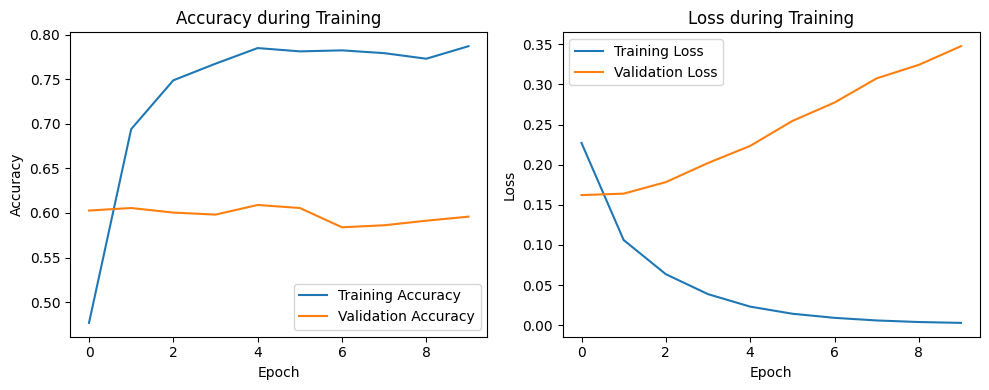

In [24]:
# Plot the training history
plt.figure(figsize=(10, 4))

# Accuracy/validation accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Loss/validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

# Selected 7 Codes

The subsequent section will utalise a smaller subset of the whole data. This subset only contains the set of selected 7 codes by Beyond Blood, these codes are (removed repeated codes):

- A61B5/00     
- A61B17/00      
- G06N20/00
- G06K9/00  
- G16H10/00
- A61B6/00



The following models will be tested to get the accuracy and hamming loss:

- Logistic Regression
- Random Forest Classifier
- Support Vector Machine
- Deep Nerual Networks

In [25]:
# Load the data for selected 7 codes by Beyond Blood
df = pd.read_csv('Data_Preprocessed_MainGroup_Selected7.csv')
df['Classification Codes'] = df['Classification Codes'].apply(ast.literal_eval)
df.head()

,Context,Classification Codes
0,processor compil system receiv predict model r...,[G06N20/00]
1,system method secur cloudbas physiolog data pr...,"[A61B5/00, G16H10/00]"
2,collim detector base medic imag system medic i...,[A61B6/00]
3,method devic determin relat two entiti method ...,"[G06N20/00, G06K9/00]"
4,system method teach composition convolut neura...,[G06K9/00]


In [26]:
# Encode the "Classification Codes" column as multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Classification Codes'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Context'], y, test_size=0.2, random_state=42)

In [27]:
# Apply feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## Logistic Regression 

In [28]:
logistic_regression = LogisticRegression()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(logistic_regression)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.46808510638297873
Hamming Loss: 0.11746249632316894


## Random Forest 

In [29]:
classifier = RandomForestClassifier()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.4447494852436513
Hamming Loss: 0.11059907834101383


## Support Vector Machine  (One vs Rest)


In [30]:
svm_classifier = SVC(kernel='linear')

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(svm_classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.426904598490048
Hamming Loss: 0.12922835572114913


## Deep Neural Networks

In [31]:
# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build the deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Make predictions
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
hamming_loss_value = hamming_loss(y_test, y_pred)

Epoch 1/10
146/146 [==============================] - 2s 11ms/step - loss: 0.3114 - accuracy: 0.6279 - val_loss: 0.2332 - val_accuracy: 0.7136
Epoch 2/10
146/146 [==============================] - 1s 9ms/step - loss: 0.1535 - accuracy: 0.8039 - val_loss: 0.2445 - val_accuracy: 0.7033
Epoch 3/10
146/146 [==============================] - 1s 9ms/step - loss: 0.0820 - accuracy: 0.8633 - val_loss: 0.2905 - val_accuracy: 0.6904
Epoch 4/10
146/146 [==============================] - 1s 9ms/step - loss: 0.0446 - accuracy: 0.8878 - val_loss: 0.3255 - val_accuracy: 0.6938
Epoch 5/10
146/146 [==============================] - 1s 9ms/step - loss: 0.0257 - accuracy: 0.8968 - val_loss: 0.3676 - val_accuracy: 0.6998
Epoch 6/10
146/146 [==============================] - 1s 9ms/step - loss: 0.0138 - accuracy: 0.8944 - val_loss: 0.4035 - val_accuracy: 0.6818
Epoch 7/10
146/146 [==============================] - 1s 9ms/step - loss: 0.0080 - accuracy: 0.9015 - val_loss: 0.4449 - val_accuracy: 0.6981
Epoch

In [32]:
# Get accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy and validation accuracy for each epoch
for epoch in range(len(accuracy)):
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")
    
# Print hamming loss
print("\nHamming Loss:", hamming_loss_value)

Epoch 1 - Accuracy: 0.6279, Validation Accuracy: 0.7136
Epoch 2 - Accuracy: 0.8039, Validation Accuracy: 0.7033
Epoch 3 - Accuracy: 0.8633, Validation Accuracy: 0.6904
Epoch 4 - Accuracy: 0.8878, Validation Accuracy: 0.6938
Epoch 5 - Accuracy: 0.8968, Validation Accuracy: 0.6998
Epoch 6 - Accuracy: 0.8944, Validation Accuracy: 0.6818
Epoch 7 - Accuracy: 0.9015, Validation Accuracy: 0.6981
Epoch 8 - Accuracy: 0.8979, Validation Accuracy: 0.6904
Epoch 9 - Accuracy: 0.8981, Validation Accuracy: 0.6852
Epoch 10 - Accuracy: 0.9000, Validation Accuracy: 0.6801

Hamming Loss: 0.09814687714481812


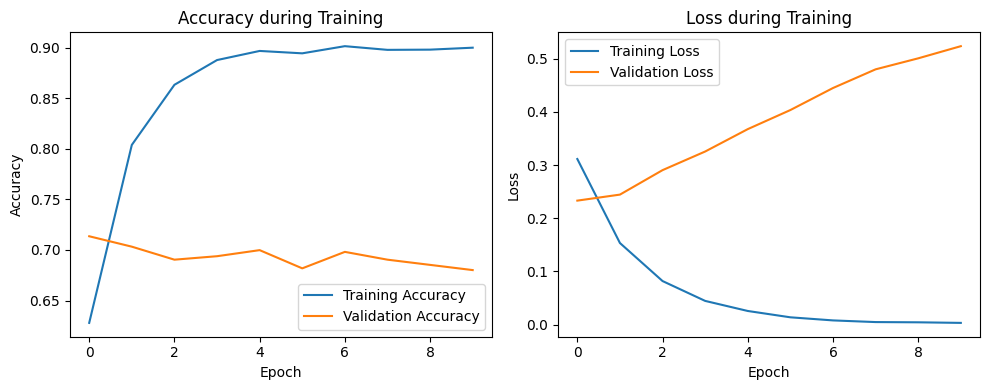

In [33]:
# Plot the training history
plt.figure(figsize=(10, 4))

# Accuracy/validation accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Loss/validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

# Results
This section presents all results from the model into a table format for ease of visualisation

In [75]:
def results_table(data):
    table = PrettyTable()
    
    # Define column headers
    table.field_names = ["Model", "Accuracy", "Hamming Loss"]
    
    # Add data
    for row in data:
        table.add_row(row)
        
    # Align data
    table.align["Model"] = "l"
    table.align["Accuracy"] = "r"
    table.align["Hamming Loss"] = "r"
    table.float_format = ".4"

    print(table)

In [78]:
# Data for the table
data_all = [
    ["Logistic Regression", 0.0784, 0.0081],
    ["Random Forest", 0.0527, 0.0072],
    ["Support Vector Machine", 0.0643, 0.0096],
    ["Deep Neural Networks", 0.3693, 0.0073]
]

data_top18 = [
    ["Logistic Regression", 0.3091, 0.0741],
    ["Random Forest", 0.2635, 0.0732],
    ["Support Vector Machine", 0.2758, 0.0839],
    ["Deep Neural Networks", 0.6090, 0.0645]
]

data_selected7 = [
    ["Logistic Regression", 0.4681, 0.1175],
    ["Random Forest", 0.4447, 0.1106],
    ["Support Vector Machine", 0.4269, 0.1292],
    ["Deep Neural Networks", 0.6998, 0.0981]
]

print("\t\t       \033[1mAll Data\033[0m")
results_table(data_all)

print("\n\n\t\t        \033[1mTop 18\033[0m")
results_table(data_top18)

print("\n\n\t\t       \033[1mSelected 7\033[0m")
results_table(data_selected7)

		       All Data
+------------------------+----------+--------------+
| Model                  | Accuracy | Hamming Loss |
+------------------------+----------+--------------+
| Logistic Regression    |   0.0784 |       0.0081 |
| Random Forest          |   0.0527 |       0.0072 |
| Support Vector Machine |   0.0643 |       0.0096 |
| Deep Neural Networks   |   0.3693 |       0.0073 |
+------------------------+----------+--------------+


		        Top 18
+------------------------+----------+--------------+
| Model                  | Accuracy | Hamming Loss |
+------------------------+----------+--------------+
| Logistic Regression    |   0.3091 |       0.0741 |
| Random Forest          |   0.2635 |       0.0732 |
| Support Vector Machine |   0.2758 |       0.0839 |
| Deep Neural Networks   |   0.6090 |       0.0645 |
+------------------------+----------+--------------+


		       Selected 7
+------------------------+----------+--------------+
| Model                  | Accuracy | Ha